In [2]:
import yfinance as yf
import random
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# yfinance testen
isin = "US0378331005"
ticker = yf.Ticker(isin)

# Das Tickersymbol anzeigen
# print(ticker.info['industry'])
# print(ticker.info)

In [4]:
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t')
cio_sell_list = ['CH0010645932', 'CH0025238863', 'CH0025751329', 'CH0126881561']
europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland']
asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan']
forex = {
    'CHF':1.,
    'EUR':0.9549,
    'USD':0.9023,
    'GBp':1.0953, # achtung, yfinance nutzt lowercase p
    'GBP':1.0953,
    'NOK':0.0808,
    'JPY':0.00603,
    'HKD':0.1153,
    'KRW':0.00067,
    'TWD':0.0278
}

market_colors = {
    'United States':'green',
    'Europe':'royalblue',
    'Switzerland':'red',
    'Asia & EM':'pink'
}

sector_colors = {
    'Financial Services':'lightblue', 
    'Technology':'silver', 
    'Industrials':'steelblue', 
    'Energy':'orange', 
    'Healthcare':'lightgreen', 
    'Consumer Defensive':'tan', 
    'Consumer Cyclical':'mediumpurple', 
    'Basic Materials':'saddlebrown', 
    'Real Estate':'maroon', 
    'Communication Services':'gold', 
    'Utilities':'teal'
}

In [5]:
class Investor:
    # Klassenattribute

    def __init__(self, id:int, name, portfolio, investor_type):
        # Instanzattribute
        self._id = id
        self._name = name
        self._portfolio = portfolio
        self._investor_type = investor_type
        self._portfolio_curreny = 'CHF'     # Momentan fix CHF
        self._portfolio_value = 0
        self._bulk_risks = []
        self._sell_stocks = []
        self._market_allocation = {}
        self._sector_allocation = {}
        self._market_allocation_difference = {}
        self._sector_allocation_difference = {}

    # Methoden
    def get_name(self):
        return f"Investor's name is {self._name}."

    def calculate_allocation_difference(self):
        pass

    def find_bulk_risks(self):
        pass

    def find_sell_stocks(self):
        # Portfolio durchsuchen nach Aktien, die auf der Sell-Liste sind
        for i in range(len(self._portfolio)):
            if self._portfolio[i]['isin'] in cio_sell_list and self._portfolio[i]['isin'] not in self._sell_stocks:
                self._sell_stocks.append(self._portfolio[i]['isin'])
                print(f"Attention! ISIN {self._portfolio[i]['isin']} is on the CIO 'Least Preferred' list.")
        if self._sell_stocks == []:
            print(f"No current positions in the portfolio are on the CIO 'Least Preferred' list.")

    def buy(self, isin, quantity):
        # Überprüfen, ob ISIN existiert
        existing_isin = isin in stock_info['isin'].values
        if not existing_isin:
            return print(f'ISIN could not be found. Please check your input.')
        
        else:
            print(f"Buying {quantity} units of ISIN {isin}...")

            # Checken, ob bereits im Portfolio
            already_bought = False
            for i in range(len(self._portfolio)): # Mehrfache Einträge der selben Aktie vermeiden; Position erhöhen
                if self._portfolio[i]['isin'] == isin: # Falls Position im Portfolio, vorhandene Position erhöhen
                    already_bought = True
                    print(f'Position already in portfolio, increasing quantity by {quantity}.')
                    self._portfolio[i]['quantity'] += quantity
                    print(f'Updated position: {self._portfolio[i]["quantity"]} units of ISIN {self._portfolio[i]["isin"]}')
                    break
            if already_bought == False: # Falls noch nicht im Portfolio, neue Position
                self._portfolio.append({'isin':isin, 'quantity':quantity})
                print(f'New position.\nSuccessfully bought {quantity} units of ISIN {isin}.')

            print(f'Purchase successfully completed!')

    def fetch_portfolio_infos(self):
        # aus stock_info Daten zu den Positionen fetchen & zuweisen
        print('Fetching data for each portfolio position.')
        stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df

        self._portfolio_value = 0

        for position in self._portfolio:
            # Infos zum relevanten Stock extrahieren
            info = stock_info.loc[stock_info['isin'] == position['isin'], ['isin', 'longName', 'previousClose', 'currency', 'country' , 'sector', 'industry']] # zeile aus stock-info von dieser Aktie
            
            # Infos zuweisen
            position['name'] = info['longName'].values[0]       # Name
            position['price'] = info['previousClose'].values[0] # Preis
            position['currency'] = info['currency'].values[0]   # Währung
            position['value'] = round(position['quantity']*position['price']*forex[position['currency']], 2) # Wert = Anzahl*Preis*Wechselkurs
            self._portfolio_value += position['value']          # Gesamt-Portfoliowert aktualisieren
            position['sector'] = info['sector'].values[0]       # Sektor
            position['industry'] = info['industry'].values[0]   # Subsektor
            position['country'] = info['country'].values[0]     # Land

            # Region für Allokation
            if position['country'] in europe_countries:
                position['region'] = 'Europe'
            elif position['country'] in asia_em_countries:
                position['region'] = 'Asia & EM'
            else:
                position['region'] = position['country'] # Switzerland & United States

        # Anteil am Portfoliowert für jede Position
        print('Updating portfolio value.')
        for position in self._portfolio:
            position['portfolio_percent'] = round(position['value']/self._portfolio_value, 4)
        print('All infos fetched and positions updated')
        print(f"Updated portfolio value: {self._portfolio_value}")

    def calculate_allocation(self):
        # Berechnung der Markt- und Sektorallokation des Portfolios
        print('Calculating Market and Sector Allocation.')

        # Zuerst: Leere Allokation
        self._market_allocation = {
            'United States':0.,
            'Europe':0.,
            'Switzerland':0.,
            'Asia & EM':0.
        }
        self._sector_allocation = {
            'Financial Services': 0, 
            'Technology': 0., 
            'Industrials': 0., 
            'Energy': 0., 
            'Healthcare': 0., 
            'Consumer Defensive': 0., 
            'Consumer Cyclical': 0., 
            'Basic Materials': 0., 
            'Real Estate': 0., 
            'Communication Services': 0., 
            'Utilities': 0.
        }
        # Aggregation
        for position in self._portfolio:
            region = position['region']
            self._market_allocation[region] += position['portfolio_percent']
            sector = position['sector']
            self._sector_allocation[sector] += position['portfolio_percent']
        print('Allocation successfully calculated.')

    def visualize_allocations(self, market=True, sector=True):
        # Allokation Visualisieren
        if market: # Markt Allokation
            market_label_list = []
            market_size_list = []
            market_color_list = []
            for market in self._market_allocation:
                if self._market_allocation[market] != 0:
                    market_label_list.append(market)
                    market_size_list.append(self._market_allocation[market])
                    market_color_list.append(market_colors[market])

            plt.pie(x=market_size_list, labels=market_label_list, autopct='%1.1f%%', colors=market_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Market Allocation')
            plt.show()

        if sector: # Sektor Allokation
            sector_label_list = []
            sector_size_list = []
            sector_color_list = []
            for sector in self._sector_allocation:
                if self._sector_allocation[sector] != 0:
                    sector_label_list.append(sector)
                    sector_size_list.append(self._sector_allocation[sector])
                    sector_color_list.append(sector_colors[sector])

            plt.pie(x=sector_size_list, labels=sector_label_list, autopct='%1.1f%%', colors=sector_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Sector Allocation')
            plt.show()

    def random_portfolio(self):
        pass

    def write_JSON(self):
        pass

    def __str__(self) -> str:
        return f"Investor's name is {self._name}."
    
    def __repr__(self):
        return f"{self._name}"

__________
Start of Testing
__________

In [34]:
# Test: Random Investor
investors = []

def random_investor():
    rand_id = ''
    for i in range(6):
        rand_id+=(str(random.randint(0,9)))
    
    name = "Raphael"
    empty_portfolio = []

    investors.append(Investor(rand_id, name, empty_portfolio, "swiss_bias"))

random_investor()
investors


[Raphael]

In [35]:
investors[0]._sell_stocks
investors[0]._portfolio
investors[0]._id
investors[0]._portfolio
# investors[0]._market_allocation

[]

In [36]:
# Test: Aktie kaufen
investors[0].buy(isin='CH0418792922', quantity=10)
print(investors[0]._portfolio)

Buying 10 units of ISIN CH0418792922...
New position.
Successfully bought 10 units of ISIN CH0418792922.
Purchase successfully completed!
[{'isin': 'CH0418792922', 'quantity': 10}]


In [37]:
# Test: andere Aktie kaufen
investors[0].buy(isin='CH0025751329', quantity=10)
print(investors[0]._portfolio)

Buying 10 units of ISIN CH0025751329...
New position.
Successfully bought 10 units of ISIN CH0025751329.
Purchase successfully completed!
[{'isin': 'CH0418792922', 'quantity': 10}, {'isin': 'CH0025751329', 'quantity': 10}]


In [38]:
# Test: einige Aktien kaufen
investors[0].buy(isin='JP3732000009', quantity=200)
investors[0].buy(isin='CH0025751329', quantity=50)
investors[0].buy(isin='US0378331005', quantity=15)
investors[0].buy(isin='US6541061031', quantity=15)
investors[0].buy(isin='US0378331005', quantity=15)
investors[0].buy(isin='FR0000121485', quantity=10)
investors[0].buy(isin='CH0011075394', quantity=10)
investors[0].buy(isin='CH0012214059', quantity=10)
investors[0].buy(isin='CH0030170408', quantity=15)
investors[0].buy(isin='IT0003128367', quantity=15)
investors[0].buy(isin='FR0000120073', quantity=10)
investors[0].buy(isin='DE0005557508', quantity=10)
investors[0].buy(isin='CH0038863350', quantity=15)
investors[0].buy(isin='CH0018294154', quantity=15)
investors[0].buy(isin='CH0012221716', quantity=10)

Buying 200 units of ISIN JP3732000009...
New position.
Successfully bought 200 units of ISIN JP3732000009.
Purchase successfully completed!
Buying 50 units of ISIN CH0025751329...
Position already in portfolio, increasing quantity by 50.
Updated position: 60 units of ISIN CH0025751329
Purchase successfully completed!
Buying 15 units of ISIN US0378331005...
New position.
Successfully bought 15 units of ISIN US0378331005.
Purchase successfully completed!
Buying 15 units of ISIN US6541061031...
New position.
Successfully bought 15 units of ISIN US6541061031.
Purchase successfully completed!
Buying 15 units of ISIN US0378331005...
Position already in portfolio, increasing quantity by 15.
Updated position: 30 units of ISIN US0378331005
Purchase successfully completed!
Buying 10 units of ISIN FR0000121485...
New position.
Successfully bought 10 units of ISIN FR0000121485.
Purchase successfully completed!
Buying 10 units of ISIN CH0011075394...
New position.
Successfully bought 10 units of IS

In [39]:
investors[0]._portfolio

[{'isin': 'CH0418792922', 'quantity': 10},
 {'isin': 'CH0025751329', 'quantity': 60},
 {'isin': 'JP3732000009', 'quantity': 200},
 {'isin': 'US0378331005', 'quantity': 30},
 {'isin': 'US6541061031', 'quantity': 15},
 {'isin': 'FR0000121485', 'quantity': 10},
 {'isin': 'CH0011075394', 'quantity': 10},
 {'isin': 'CH0012214059', 'quantity': 10},
 {'isin': 'CH0030170408', 'quantity': 15},
 {'isin': 'IT0003128367', 'quantity': 15},
 {'isin': 'FR0000120073', 'quantity': 10},
 {'isin': 'DE0005557508', 'quantity': 10},
 {'isin': 'CH0038863350', 'quantity': 15},
 {'isin': 'CH0018294154', 'quantity': 15},
 {'isin': 'CH0012221716', 'quantity': 10}]

In [40]:
# Test: Sell-stocks identifizieren
investors[0].find_sell_stocks()

Attention! ISIN CH0025751329 is on the CIO 'Least Preferred' list.


In [41]:
# Test: Sell-Stocks ausgeben
investors[0]._sell_stocks

['CH0025751329']

In [42]:
# Test: Fetch-Portfolio_infos
investors[0].fetch_portfolio_infos()

Fetching data for each portfolio position.
Updating portfolio value.
All infos fetched and positions updated
Updated portfolio value: 35123.54


In [43]:
# Test: Portfolio ausgeben nach dem Fetch
investors[0]._portfolio

[{'isin': 'CH0418792922',
  'quantity': 10,
  'name': 'Sika AG',
  'price': 222.2,
  'currency': 'CHF',
  'value': 2222.0,
  'sector': 'Basic Materials',
  'industry': 'Specialty Chemicals',
  'country': 'Switzerland',
  'region': 'Switzerland',
  'portfolio_percent': 0.0633},
 {'isin': 'CH0025751329',
  'quantity': 60,
  'name': 'Logitech International S.A.',
  'price': 64.78,
  'currency': 'CHF',
  'value': 3886.8,
  'sector': 'Technology',
  'industry': 'Computer Hardware',
  'country': 'Switzerland',
  'region': 'Switzerland',
  'portfolio_percent': 0.1107},
 {'isin': 'JP3732000009',
  'quantity': 200,
  'name': 'SoftBank Corp.',
  'price': 1671.5,
  'currency': 'JPY',
  'value': 2015.83,
  'sector': 'Communication Services',
  'industry': 'Telecom Services',
  'country': 'Japan',
  'region': 'Asia & EM',
  'portfolio_percent': 0.0574},
 {'isin': 'US0378331005',
  'quantity': 30,
  'name': 'Apple Inc.',
  'price': 178.72,
  'currency': 'USD',
  'value': 4837.77,
  'sector': 'Techno

In [44]:
investors[0]._portfolio_value

35123.54

In [45]:
# Test: Allokationen berechnen
investors[0].calculate_allocation()

Calculating Market and Sector Allocation.
Allocation successfully calculated.


In [46]:
investors[0]._market_allocation
investors[0]._sector_allocation

{'Financial Services': 0.1227,
 'Technology': 0.2484,
 'Industrials': 0.19870000000000002,
 'Energy': 0.0,
 'Healthcare': 0.0,
 'Consumer Defensive': 0.0442,
 'Consumer Cyclical': 0.1506,
 'Basic Materials': 0.12309999999999999,
 'Real Estate': 0.0471,
 'Communication Services': 0.0629,
 'Utilities': 0.0023}

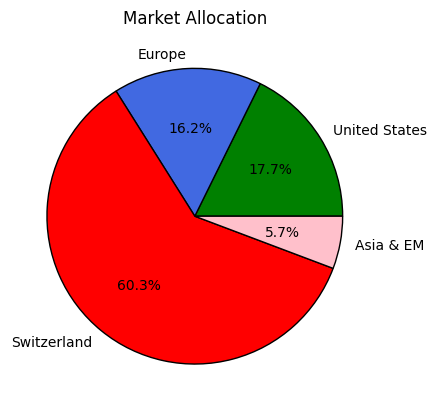

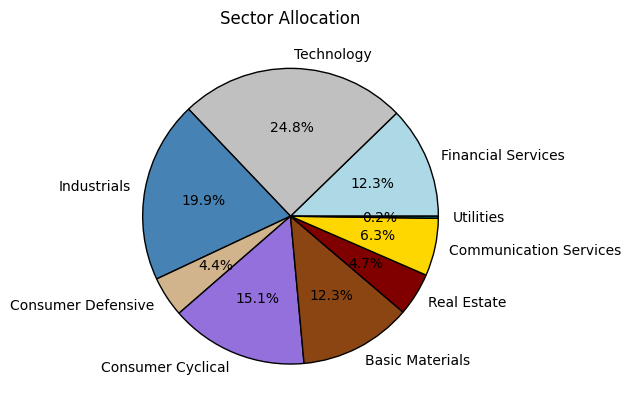

In [47]:
# Testing: Allokation visualisieren
investors[0].visualize_allocations()

__________
End of Testing
__________

In [483]:
# IMPLEMENTED

# Allokation berechnen

market_allocation = {
    'United States':0.,
    'Europe':0.,
    'Switzerland':0.,
    'Asia & EM':0.
}

sector_allocation = {
    'Financial Services': 0, 
    'Technology': 0., 
    'Industrials': 0., 
    'Energy': 0., 
    'Healthcare': 0., 
    'Consumer Defensive': 0., 
    'Consumer Cyclical': 0., 
    'Basic Materials': 0., 
    'Real Estate': 0., 
    'Communication Services': 0., 
    'Utilities': 0.
}

for position in investors[0]._portfolio:
    region = position['region']
    market_allocation[region] += position['portfolio_percent']
    sector = position['sector']
    sector_allocation[sector] += position['portfolio_percent']

market_allocation
# sector_allocation

{'United States': 0.3992,
 'Europe': 0.20029999999999998,
 'Switzerland': 0.3814,
 'Asia & EM': 0.0189}

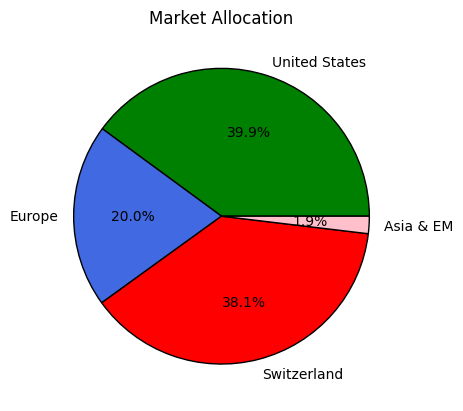

In [484]:
# IMPLEMENTED

# Allokation visualiseren
market_colors = {
    'United States':'green',
    'Europe':'royalblue',
    'Switzerland':'red',
    'Asia & EM':'pink'
}

sector_colors= {}

market_label_list = []
market_size_list = []
market_color_list = []
for market in market_allocation:
    if market_allocation[market] != 0:
        market_label_list.append(market)
        market_size_list.append(market_allocation[market])
        market_color_list.append(market_colors[market])

plt.pie(x=market_size_list, labels=market_label_list, autopct='%1.1f%%', colors=market_color_list, wedgeprops=dict(edgecolor='black'))
plt.title('Market Allocation')
plt.show()

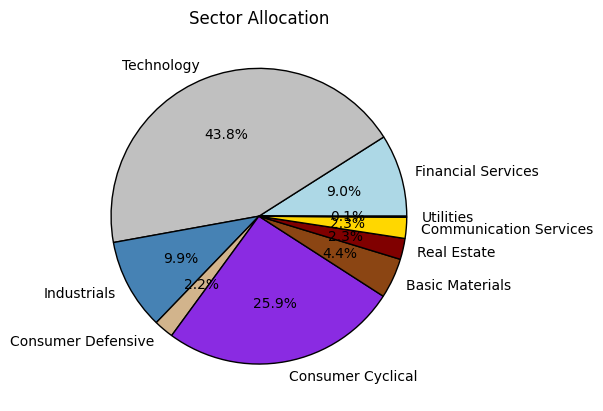

In [485]:
sector_colors = {
    'Financial Services':'lightblue', 
    'Technology':'silver', 
    'Industrials':'steelblue', 
    'Energy':'orange', 
    'Healthcare':'lightgreen', 
    'Consumer Defensive':'tan', 
    'Consumer Cyclical':'blueviolet', 
    'Basic Materials':'saddlebrown', 
    'Real Estate':'maroon', 
    'Communication Services':'gold', 
    'Utilities':'teal'
}

sector_label_list = []
sector_size_list = []
sector_color_list = []
for sector in sector_allocation:
    if sector_allocation[sector] != 0:
        sector_label_list.append(sector)
        sector_size_list.append(sector_allocation[sector])
        sector_color_list.append(sector_colors[sector])

plt.pie(x=sector_size_list, labels=sector_label_list, autopct='%1.1f%%', colors=sector_color_list, wedgeprops=dict(edgecolor='black'))
plt.title('Sector Allocation')
plt.show()

In [24]:
# referenz-allokation laden
profile = 'swiss-bias'
with open(f'..\data\profile_{profile}.json') as json_file:
    reference_allocation = json.load(json_file)
    print("Type:", type(reference_allocation))

Type: <class 'dict'>


In [25]:
print(reference_allocation)

{'name': 'Swiss-Bias Investor', 'markets': {'USA': 0.15, 'Europe': 0.1, 'Switzerland': 0.7, 'Asia & EM': 0.05}, 'sectors': {'Financial Services': 0.18, 'Technology': 0.08, 'Industrials': 0.15, 'Energy': 0.02, 'Healthcare': 0.25, 'Consumer Defensive': 0.15, 'Consumer Cyclical': 0.08, 'Basic Materials': 0.05, 'Real Estate': 0.0, 'Communication Services': 0.02, 'Utilities': 0.02}}


In [26]:
# json-file laden
with open(f'..\data\dummy_portfolio.json') as json_file:
    dummy_portfolio = json.load(json_file)
    print("Type:", type(dummy_portfolio))

Type: <class 'dict'>


In [27]:
print(dummy_portfolio)

{'id': '000001', 'name': 'John Doe', 'investor_type': 'Swiss-Bias', 'portfolio': [{'name': 'ABB', 'isin': 'CH0012221716', 'quantity': 10}, {'name': 'Ralp Lauren', 'isin': 'US7512121010', 'quantity': 15}], 'banker': [{'name': 'UBS', 'isin': 'CH0244767585', 'quantity': 10}, {'name': 'Zurich', 'isin': 'CH0011075394', 'quantity': 15}], 'tech_guy': [{'name': 'Apple', 'isin': 'US0378331005', 'quantity': 10}, {'name': 'Microsoft', 'isin': 'US5949181045', 'quantity': 15}], 'bad_stocks': [{'isin': 'CH0012221716'}, {'isin': 'US7512121010'}], 'market_allocation': {'USA': 0.5, 'Europe': 0.0, 'Switzerland': 0.5, 'Asia & EM': 0.0}, 'sector_allocation': {'Financial Services': 0.01, 'Technology': 0.01, 'Industrials': 0.01, 'Energy': 0.01, 'Healthcare': 0.01, 'Consumer Defensive': 0.01, 'Consumer Cyclical': 0.01, 'Basic Materials': 0.01, 'Real Estate': 0.01, 'Communication Services': 0.01, 'Utilities': 0.01}, 'market_allocation_difference': {'USA': 0.35, 'Europe': -0.1, 'Switzerland': -0.2, 'Asia & EM'

In [28]:
# IMPLEMENTIERT
# stock-info laden
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t')
# stock_info['isin'].head()
stock_info['longName'].head()
stock_info['industry'].head(10)

0      Electrical Equipment & Parts
1    Medical Instruments & Supplies
2     Building Products & Equipment
3               Specialty Chemicals
4                Building Materials
5    Integrated Freight & Logistics
6                 Computer Hardware
7            Diagnostics & Research
8                    Packaged Foods
9      Drug Manufacturers - General
Name: industry, dtype: object

In [29]:
print(stock_info.columns)

Index(['address1', 'city', 'zip', 'country', 'phone', 'fax', 'website',
       'industry', 'industryKey', 'industryDisp',
       ...
       'shortPercentOfFloat', 'totalAssets', 'navPrice', 'beta3Year',
       'fundFamily', 'fundInceptionDate', 'legalType', 'yield', 'ytdReturn',
       'threeYearAverageReturn'],
      dtype='object', length=146)


In [145]:
# test-portfolio
portfolio = []
isin_list = ['CH0038863350', 'US4581401001', 'CH0009002962', 'DE000A1EWWW0', 'FR0000120073', 'NL0010273215', 'GB00B7KR2P84', 'JE00B4T3BW64', 'LU0480132876', 'HK0000069689', 'KYG017191142', 'GB0005405286', 'KYG6427A1022', 'KR7005930003', 'TW0002330008', 'NL0011585146', 'JP3732000009']
quantity_list = [10, 30, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# quantity_list = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

for i in range(len(isin_list)):
    portfolio.append({'isin':isin_list[i], 'quantity':quantity_list[i]})
portfolio

[{'isin': 'CH0038863350', 'quantity': 10},
 {'isin': 'US4581401001', 'quantity': 30},
 {'isin': 'CH0009002962', 'quantity': 15},
 {'isin': 'DE000A1EWWW0', 'quantity': 1},
 {'isin': 'FR0000120073', 'quantity': 2},
 {'isin': 'NL0010273215', 'quantity': 3},
 {'isin': 'GB00B7KR2P84', 'quantity': 4},
 {'isin': 'JE00B4T3BW64', 'quantity': 5},
 {'isin': 'LU0480132876', 'quantity': 6},
 {'isin': 'HK0000069689', 'quantity': 7},
 {'isin': 'KYG017191142', 'quantity': 8},
 {'isin': 'GB0005405286', 'quantity': 9},
 {'isin': 'KYG6427A1022', 'quantity': 10},
 {'isin': 'KR7005930003', 'quantity': 11},
 {'isin': 'TW0002330008', 'quantity': 12},
 {'isin': 'NL0011585146', 'quantity': 13},
 {'isin': 'JP3732000009', 'quantity': 14}]

In [134]:
# IMPLEMENTIERT

# Kaufen
isin = 'US123'
quantity = 5

print(f"Buying {quantity} units of ISIN {isin}...")

# Checken, ob bereits im portfolio
already_bought = False
for i in range(len(portfolio)):
    if portfolio[i]['isin'] == isin:
        already_bought = True
        print(f"Position already in Portfolio, increasing quantity by {quantity}.")
        portfolio[i]['quantity'] += quantity
        print(f'Updated Position: {portfolio[i]["quantity"]} units of ISIN {portfolio[i]["isin"]}')
        break
if already_bought == False:
    portfolio.append({'isin':isin, 'quantity':quantity})
    print(f'New Position.\nSuccessfully bought {quantity} units of ISIN {isin}.')

print(f'Purchase successfully completed!')



# portfolio.append({'isin':'CH0038863350', 'quantity':5})

Buying 5 units of ISIN US123...
New Position.
Successfully bought 5 units of ISIN US123.
Purchase successfully completed!


In [149]:
# IMPLEMENTIERT
# mit portfolio-positionen die daten aus stock-data holen für allokation

europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland']
asia_stocks = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan']

portfolio_currency = 'CHF'
forex = {
    'CHF':1.,
    'EUR':0.9549,
    'USD':0.9023,
    'GBp':1.0953, # achtung, yfinance nutzt lowercase p
    'GBP':1.0953,
    'NOK':0.0808,
    'JPY':0.00603,
    'HKD':0.1153,
    'KRW':0.00067,
    'TWD':0.0278
}

portfolio_value = 0 # variable für gesamtwert des portfolios
for position in portfolio:
    # relevante Infos fetchen
    info = stock_info.loc[stock_info['isin'] == position['isin'], ['isin', 'longName', 'previousClose', 'currency', 'country' , 'sector']] # zeile aus stock-info von dieser Aktie
    
    position['name'] = info['longName'].values[0]       # Name
    position['price'] = info['previousClose'].values[0] # Preis
    position['currency'] = info['currency'].values[0]   # Währung
    position['value'] = round(position['quantity']*position['price']*forex[position['currency']], 2) # Wert = Anzahl*Preis*Wechselkurs
    portfolio_value += position['value']    # Portfoliowert aktualisieren
    position['country'] = info['country'].values[0]     # Land

    # Region für Allokation
    if position['country'] in europe_countries:
        position['region'] = 'Europe'
    elif position['country'] in asia_stocks:
        position['region'] = 'Asia'
    else:
        position['region'] = position['country']
    position['sector'] = info['sector'].values[0]

# Anteil am Portfoliowert für jede Position
for position in portfolio:
    position['portfolio_percent'] = round(position['value']/portfolio_value, 4)
    
print(portfolio_value)
print(portfolio)
# print(portfolio)

40930.34999999999
[{'isin': 'CH0038863350', 'quantity': 10, 'name': 'Nestlé S.A.', 'price': 103.42, 'currency': 'CHF', 'value': 1034.2, 'country': 'Switzerland', 'sector': 'Consumer Defensive', 'portfolio_percent': 0.0253, 'region': 'Switzerland'}, {'isin': 'US4581401001', 'quantity': 30, 'name': 'Intel Corporation', 'price': 36.56, 'currency': 'USD', 'value': 989.64, 'country': 'United States', 'sector': 'Technology', 'portfolio_percent': 0.0242, 'region': 'United States'}, {'isin': 'CH0009002962', 'quantity': 15, 'name': 'Barry Callebaut AG', 'price': 1383.0, 'currency': 'CHF', 'value': 20745.0, 'country': 'Switzerland', 'sector': 'Consumer Defensive', 'portfolio_percent': 0.5068, 'region': 'Switzerland'}, {'isin': 'DE000A1EWWW0', 'quantity': 1, 'name': 'adidas AG', 'price': 170.96, 'currency': 'EUR', 'value': 163.25, 'country': 'Germany', 'sector': 'Consumer Cyclical', 'portfolio_percent': 0.004, 'region': 'Europe'}, {'isin': 'FR0000120073', 'quantity': 2, 'name': "L'Air Liquide S.A

In [147]:
testy = 0
for i in range(len(portfolio)):
    print(portfolio[i]['value'])
    testy += portfolio[i]['value']
print(f'Portfolio Value: {testy}')

1034.2
989.64
20745.0
163.25
304.31
1641.19
1711.3
2534.8
517.62
56.01
75.64
6437.08
188.52
511.48
183.81
3695.39
141.11
Portfolio Value: 40930.34999999999


In [167]:
testy2 = 0
for i in range(len(portfolio)):
    print(portfolio[i]['portfolio_percent'])
    testy2 += portfolio[i]['portfolio_percent']
print(f'Portfolio Total Percent: {testy2}')

0.0253
0.0242
0.5068
0.004
0.0074
0.0401
0.0418
0.0619
0.0126
0.0014
0.0018
0.1573
0.0046
0.0125
0.0045
0.0903
0.0034
Portfolio Total Percent: 0.9998999999999999


In [105]:
countries = []
for i in range(len(stock_info)):
    if stock_info['country'][i] not in countries:
        countries.append(stock_info['country'][i])
countries

['Switzerland',
 nan,
 'Germany',
 'France',
 'Netherlands',
 'Spain',
 'Italy',
 'United Kingdom',
 'Norway',
 'United States',
 'Ireland',
 'Japan',
 'Hong Kong',
 'China',
 'South Korea',
 'Taiwan']

In [106]:
currencies = []
for i in range(len(stock_info)):
    if stock_info['currency'][i] not in currencies:
        currencies.append(stock_info['currency'][i])
currencies

['CHF', 'EUR', 'USD', 'GBp', 'NOK', 'JPY', 'HKD', 'KRW', 'TWD']

In [100]:
europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland']
asia_stocks = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan']

In [73]:
# Titel ohne country
stock_info[stock_info['country'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [84]:
stock_info[stock_info['sector'].isna()]['isin']

24     CH1169151003
75     FR001400AJ45
110    LU0480132876
111    LU1169822779
Name: isin, dtype: object

In [80]:
stock_info[stock_info['previousClose'].isna()]['longName']

Series([], Name: longName, dtype: object)

In [83]:
stock_info[stock_info['industry'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [94]:
stock_info[stock_info['industry'].isna()]['dividendYield']

24    NaN
75    NaN
110   NaN
111   NaN
Name: dividendYield, dtype: float64

In [99]:
stock_info.loc[stock_info['isin'] == 'CH0038863350', ['dividendYield']]

,dividendYield
8,0.0286


In [61]:
nesn_data = stock_info.loc[stock_info['isin'] == 'CH0038863350', ['isin', 'longName', 'previousClose', 'sector']]
nesn_data


,isin,longName,previousClose,sector
8,CH0038863350,Nestlé S.A.,103.42,Consumer Defensive


In [159]:
info = stock_info.loc[stock_info['isin'] == portfolio[0]['isin']]
info

,address1,city,zip,country,phone,fax,website,industry,industryKey,industryDisp,...,shortPercentOfFloat,totalAssets,navPrice,beta3Year,fundFamily,fundInceptionDate,legalType,yield,ytdReturn,threeYearAverageReturn
8,avenue NestlE 55,Vevey,1800,Switzerland,41 21 924 11 11,NaN,https://www.nestle.com,Packaged Foods,packaged-foods,Packaged Foods,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Klasse: investor
Attribut:
portfolio isch s dictionary mit beliebig viel key:value paar wo sind ISIN:Anzahl_Aktien (CH0038863350:1400) <-- er het 1400x nestlé aktia
bad_stocks: a lista mit allna aktia wo de CIO uf "SELL" het (warnig für da user, dass er dia söll wegtua)
market_allocation isch s dictionary mit da vier märkt als key und deren %-Anteil als Value (Europe:20%)
sector_allocation: same, aber mit industriesektora (Tech:8%)
investor_type: uswahl vo eina vo da drei muster-allokationa (Swiss-Bias, Swiss-Global, Global)
market_allocation_difference: dictionary wo d unterschied zwüschet de allocation vom investor und de muster-allokation drin isch (investor het 5% USA und s muster het 35% USA -->  USA:-30%)
sector_allocation_difference: same mit sektora
Funktiona:
calculate_allocation: berechnig vo de market_allocation und de sector_allocation anhand vo sinem portfolio
calculate_allocation_differences: berechnig vo market_allocation_difference und sector_allocation_difference
find_bad_stocks: im portfolio d aktia ablicha mit de CIO lista vo "SELL" aktia, und wenn ma eini findet schribt ma sie in bad_stocks lista
buy(ISIN, Anzahl): a aktia ins portfolio kaufa
random_portfolio: portfolio fülla mit ca. 15-25 Aktia, jewiils 15'000 bis 150'000 Franka. ich glaub es söll sich a chli am investor_type usrichta, aber dörf ruhig recht random sii macht eifach das 15-25x:    random aktia ussuacha, random betrag bestimma (15-150k), betrag//(Wert vo 1 Aktia) <-- ganzzahldivision, wia viel stück ma kauft, funktion buy(ISIN, Anzahl) ufrüafa
write_JSON: pack d dictionaries in es JSON (fürs frontend) (bearbeitet)